In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm # Colormaps
%matplotlib inline

# Introduction

What if we choose to use Gaussian distributions to model our data?

$$p(x|\pi,\Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2}\exp{-\frac{1}{2}(x-\mu)'\Sigma^{-1}(x-\mu)}$$

There would not seem to be any gain doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from a multivariate normal distribution is also normal:

$$
\begin{eqnarray*}
p(x,y) & = & \mathcal{N}\left(\left[\begin{array}{c}
\mu_x\\
\mu_y
\end{array}\right],\left[\begin{array}{ccc}
\Sigma_x & \Sigma_{xy}\\
\Sigma_{xy}^T & \Sigma_y
\end{array}\right]\right)
\end{eqnarray*}
$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Also, conditional distributions of a subset of the elements of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), \Sigma_x - \Sigma_{xy}\Sigma^{-1}_{y}\Sigma_{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, with any marginal subset having a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an inifinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially implying an inifite vector that inly returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian represented as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a distribution over functions. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean function and a covariance function:

$$p(x) \sim GP(m(x), k(x,x'))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed.

For example, one specification of a GP might be:

$$\begin{aligned}
m(x)&=0 \\
k(x, x')&=\eta\exp(-\frac{\ell}{2}(x-x')^2)
\end{aligned}$$

Here, the covariance function is a squared exponential, for which values of $x$ and $x'$ that are close together result in values of $k$ closer to one, while those that are far apart return values closer to zero. It may seem odd to simply adopt the zero function to represent the mean of the Gaussian process - surely we can do better than that. It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean function and covariance function, respectively, evaluated at those points.


Gaussian processes are non-parametric methods. Instead of inferring a distribution over the parameters of a parametric function, GP can be used to infer a distribution over functions directly. It defines a prior over functions and after having observed some function values it can be converted into a posterior over functions.

A Gaussian process is a random process where any point ${x} \in \mathbb{R}^d$ is assigned a random variable $f({x})$ and where the joint distribution of a finite number of these variables $p(f(x_1),...,f(x_N))$ is itself a Gaussian:

$$p(f|X) = \mathcal{N}(f|\mu,K)$$

where $f=(f(x_1),...,f(x_N)$, $\mu=(m(x_1),...,m(x_N))$ and $K_{ij}=k(x_i,x_j)$. $m$ is the mean function and GPs are flexible enough to model the mean arbitrarily well. $k$ is a positive definite kernel function of covariance function. Thus, a Gaussian process is a distirbution over functions whose shape (smoothness,...) is defined by $K$. If points $x_i$ and $x_j$ are considered to be similar by the kernel the function values at these points, $f(x_i)$ and $f(x_j)$ can be expected to be similar too.

Given a training dataset with noise-free function values $f$ at inputs $X$, a GP prior can be converted into a GP posterior $p(f_*|X_*, X, f)$ which can then be used to make predictions $f_*$ at new inputs $X_*$. By definiton of a GP, the joint distribution of observed values $f$ and $f_*$ is again a Gaussian which can be partioned into

$$\begin{eqnarray*}
\begin{pmatrix}f\\
f_*
\end{pmatrix} & \sim & \mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
K & K_*\\
K_*^T & K_{**}
\end{array}\right]\right)
\end{eqnarray*}$$

where $K_*=k(X, X_*)$ and $K_{**}=k(X_*,X_*)$. With $N$ training data and $N_*$ new input data $K$ is a $N$x$N$ matrix, $K_*$ a $N$x$N_*$ matrix and $K_{**}$ a $N_*$x$N_{*}$ matrix. Using standard rules for conditioning Gaussians, the predictive distribution is given by

$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK^{-1}K_*
\end{aligned}$$

If we have a training dataset with noisy function values $y = f + \epsilon$, where noise is $\epsilon \sim \mathcal{N}(0, \sigma^2_yI)$ is independently added to each observation then the predictive distribution is given by

$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK_y^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK_y^{-1}K_*
\end{aligned}$$

where $K_y = K + \sigma_y^2I$. Although the equation above covers noise in the training data, it is still a distribution over noise-free predictions $f_*$. To additionally include noise $\epsilon$ into predictions $y_*$ we have to add $\sigma_y^2$ to the diagonal of $\Sigma_*$

$$p(y_*|X_*, X, y) = \mathcal{N}(y_*|\mu_*, \Sigma_* + \sigma_y^2I)$$

In [1]:
import numpy as np

def kernel(x1, x2, l=1.0, η=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        x1: Array of m points (m x d)
        x2: Array of n points (n x d)
        
    Returns:
        (m x n) matrix
    """
    sqdist = np.sum(x1**2,1).reshape(-1,1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return η**2 * np.exp(-0.5 / l**2 * sqdist)

# Multivariate Normal

The multivariate normal distribution is a multidimensional generalization of the one-dimensional normal distribution. It represents the distribution of a multivariate random variable that is made up of multiple random variables that can be correlated with each other.

Like the normal distribution, the multivariate normal is defined by sets of parameters: the man vector $\mu$, which is the expected value of the distribution and the covariance matrix $\Sigma$, which measures how dependent two random variables are and how they change together.

The multivariate normal with dimensionality $d$ has a joint probability density given by:

$$p(x|\mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}}\exp\big(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\big)$$

where $x$ is a random vector of size $d$, $\mu$ is the mean vector $\Sigma$ is the symmetric and positive definite covariance matrix (of size $d$x$d$) and $|\Sigma|$ is the determinant. We denote this multivariate normal distribution as:

$$\mathcal{N}(\mu, \Sigma)$$

In [38]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal dist"""
    x_m = x - mean
    return (1. / (np.sqrt((2*np.pi)**d * np.linalg.det(covariance))) 
            * np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m))/2))

Examples of two bivariate normal distributions are plotted below.

The figure on the left is a bivariate distribution with the covariance between $x_1$ and $x_2$ set to 0 so that these two variables are independent.

$$\begin{eqnarray*}
\mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
1 & 0\\
0 & 1
\end{array}\right]\right)
\end{eqnarray*}$$


The figure on the right is a bivariate distribution with the covariance between $x_1$ and $x_2$ set to different than 0 so that these two variables are dependent.



$$\begin{eqnarray*}
\mathcal{N}\left(\left[\begin{array}{c}
0\\
1
\end{array}\right],\left[\begin{array}{ccc}
1 & 0.8\\
0.8 & 1
\end{array}\right]\right)
\end{eqnarray*}$$


In [46]:
# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]), 
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

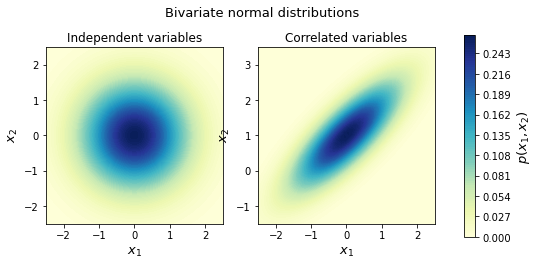

In [47]:
# subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
d = 2  # number of dimensions

# Plot of independent Normals
bivariate_mean = np.matrix([[0.], [0.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.], 
    [0., 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.set_aspect('equal')
ax1.set_title('Independent variables', fontsize=12)

# Plot of correlated Normals
bivariate_mean = np.matrix([[0.], [1.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.8], 
    [0.8, 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax2.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([-2.5, 2.5, -1.5, 3.5])
ax2.set_aspect('equal')
ax2.set_title('Correlated variables', fontsize=12)

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('Bivariate normal distributions', fontsize=13, y=0.95)
plt.show()

# Sampling from a multivariate normal

##### Affine transformations of the multivariate normal

It is possible to transform as multivariate normal distribution into a new normal distribution with an affine transformation. More specifically if $X$ is normally distributed and $Y=LX + u$ with $L$ a linear transformation and $u$ a vector then $Y$ is also normally distributed with mean $\mu_Y = u + L\mu_x$ and covariance matrix $\Sigma_Y = L\Sigma_XL^T$.

$$\begin{aligned}
Y &\sim \mathcal{N}(\mu_Y, \Sigma_Y) & X \sim \mathcal{N}(\mu_X, \Sigma_X)
\end{aligned}$$

$$\mathcal{N}(\mu_Y, \Sigma_Y) = \mathcal{N}(u + L\mu_X, L\Sigma_XL^T) = L\mathcal{N}(\mu_x, \Sigma_X)+ u$$

##### Sampling

The previous formula helps us to sample from any multivariate gaussian. To do the sampling we can sample $X$ from the standard normal distribution $X \sim \mathcal{N}(0, I_d)$, where the mean is the vector $\mu = 0$ and the covariance is the identity matrix $\Sigma = I_d$. Sampling from this distribution is easier because each variable in $X$ is independent from all other variables, we can just sample each variable separately.

It is then possible to sample $Y$ from $\mathcal{N}(\mu_Y, \Sigma_Y)$ by sampling $X$ and applying the affine transform on the samples. This transform is $Y = LX + u$ where we know from the previous sections that the covariance of $Y$ will be $\Sigma_Y = L\Sigma_XL^T$. Since $\Sigma_X = I_d$ we can write that $\Sigma_Y = LI_dL^T=LL^T$.

$L$ can now be found by a technique called Cholesky decomposition which does exactly the decomposition we need. The vector $u$ is then $\mu_Y$ since $\mu_X=0$ ($u=\mu_Y-L\mu_X$).

Let's try this out by sampling 50 samples from:

$$\begin{eqnarray*}
\mathcal{N}\left(\left[\begin{array}{c}
0\\
1
\end{array}\right],\left[\begin{array}{ccc}
1 & 0.8\\
0.8 & 1
\end{array}\right]\right)
\end{eqnarray*}$$

The sampling is done by the following code and the samples are plotted as red dots on the probability density surface below. 


In [83]:
# Sample from:
d = 2 # number of dimensions

mean = np.matrix([[0.], [1.]])
covariance = np.matrix([
    [1, 0.8],
    [0.8, 1.]
])

# Create L
L = np.linalg.cholesky(covariance)
print(L)
# Sample X form standard normal
n=50 # samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

[[1.  0. ]
 [0.8 0.6]]


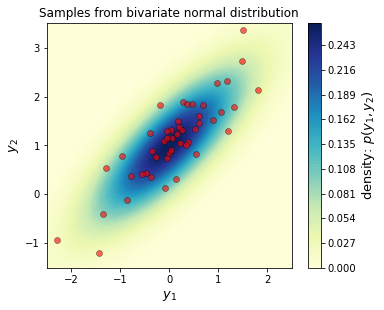

In [82]:
# Plot the samples and the distribution
fig, ax = plt.subplots(figsize=(6, 4.5))
# Plot bivariate distribution
x1, x2, p = generate_surface(mean, covariance, d)
con = ax.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
# Plot samples
ax.plot(Y[0,:], Y[1,:], 'ro', alpha=.6,
        markeredgecolor='k', markeredgewidth=0.5)
ax.set_xlabel('$y_1$', fontsize=13)
ax.set_ylabel('$y_2$', fontsize=13)
ax.axis([-2.5, 2.5, -1.5, 3.5])
ax.set_aspect('equal')
ax.set_title('Samples from bivariate normal distribution')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('density: $p(y_1, y_2)$', fontsize=13)
plt.show()
#

# Time to play around with sampling

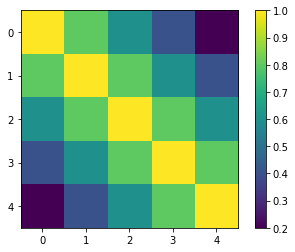

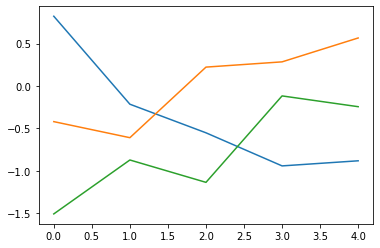

In [94]:
# Sample from:
d = 5 # number of dimensions

mean = np.zeros((d,1))
covariance = np.matrix([
    [1, 0.8, 0.6, 0.4, 0.2],
    [0.8, 1., 0.8, 0.6, 0.4],
    [0.6, 0.8, 1., 0.8, 0.6],
    [0.4, 0.6, 0.8, 1., 0.8],
    [0.2, 0.4, 0.6, 0.8, 1.],
])

# Create L
L = np.linalg.cholesky(covariance)
# Sample X form standard normal
n=3 # samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

m = plt.imshow(covariance)
plt.colorbar(m)
plt.show()

plt.plot(Y);

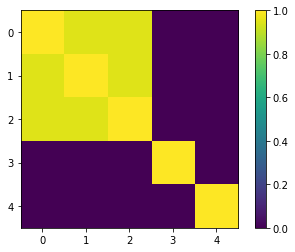

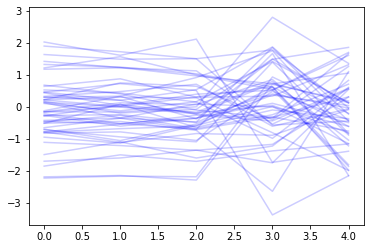

In [113]:
# Sample from:
d = 5 # number of dimensions

mean = np.array([[0.],
               [0.],
               [0.],
               [0.],
               [0.]])
covariance = np.matrix([
    [1, 0.95, 0.95, 0., 0.],
    [0.95, 1., 0.95, 0., 0.],
    [0.95, 0.95, 1., 0., 0.],
    [0., 0., 0., 1., 0.],
    [0., 0., 0., 0., 1.],
])

# Create L
L = np.linalg.cholesky(covariance)
# Sample X form standard normal
n=50 # samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

m = plt.imshow(covariance)
plt.colorbar(m)
plt.show()

plt.plot(Y, color='b', alpha=0.2);

We can see that the first three points are highly correlated and the remaining points are independent of the first points and between themselves.

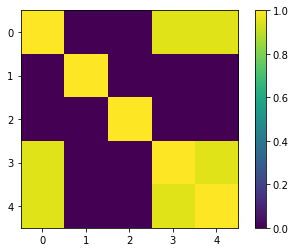

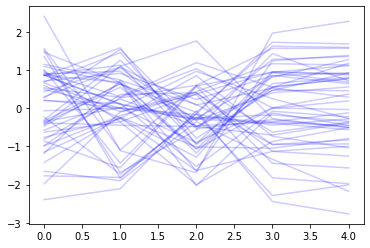

In [135]:
# Sample from:
d = 5 # number of dimensions

mean = np.array([[0.],
               [0.],
               [0.],
               [0.],
               [0.]])
covariance = np.matrix([
    [1., 0., 0., 0.95, 0.95],
    [0., 1., 0., 0., 0.],
    [0., 0., 1., 0., 0.],
    [0.95, 0., 0., 1., 0.95],
    [0.95, 0., 0., 0.95, 1.],
])

# Create L
L = np.linalg.cholesky(covariance)
# Sample X form standard normal
n=50 # samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

m = plt.imshow(covariance)
plt.colorbar(m)
plt.show()

plt.plot(Y, color='b', alpha=0.2);

First, fourth and fifth point are highly correlated while the remains are not correlated between themselves of with any of the other points. 

These are all prior realizations of a Gaussian Process.

# Prior

Let's first define a prior over functions with mean zero and covariance matrix computed with the kernel defined above. To draw random functions from that GP we draw random samples from the corresponding multivariate normal. The following example draws three random samples and plots it together with the zero mean and the 95% confidence interval (computed from the diagonal of the covariance matrix).

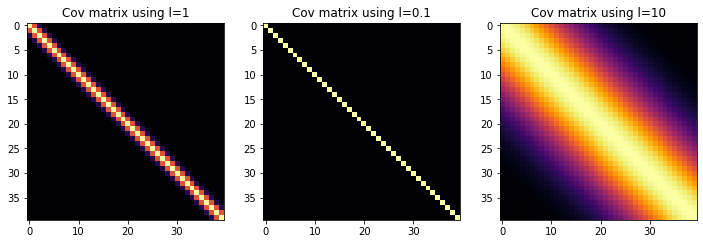

In [23]:
# Finite number of points
X = np.arange(-20, 20, 1).reshape(-1, 1)

params = [1, 0.1, 10]
# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov1 = kernel(X, X, l=params[0])

# Draw three samples from the prior
samples1 = np.random.multivariate_normal(mu.ravel(), cov1, 3)
cov2 = kernel(X, X, l=params[1])
cov3 = kernel(X, X, l=params[2])

# Draw three samples from the prior
samples2 = np.random.multivariate_normal(mu.ravel(), cov2, 3)
samples3 = np.random.multivariate_normal(mu.ravel(), cov3, 3)

samples1 = np.tile(samples1, (1, 1, 1))
samples2 = np.tile(samples2, (1, 1, 1))
samples3 = np.tile(samples3, (1, 1, 1))
samples =  np.concatenate((samples1, samples2, samples3), axis=0)

cov1 = np.tile(cov1, (1, 1, 1))
cov2 = np.tile(cov2, (1, 1, 1))
cov3 = np.tile(cov3, (1, 1, 1))
cov =  np.concatenate((cov1, cov2, cov3), axis=0)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

for idx, i in enumerate(params):
    ax[idx].imshow(cov[idx,:,:], cmap="inferno", interpolation='none')
    ax[idx].set_title(f'Cov matrix using l={i}')

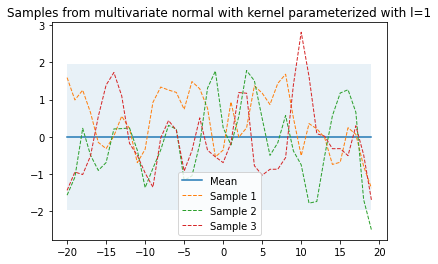

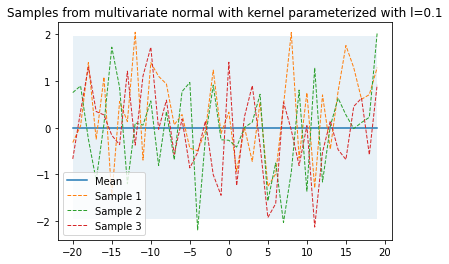

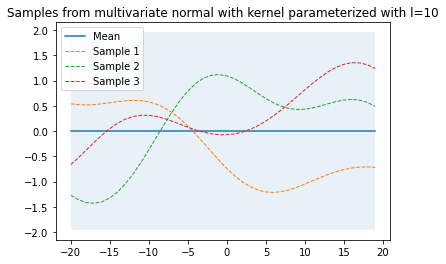

In [25]:
# Plot GP mean, confidence interval and samples 

def plot_gp(mu, cov, X, X_train=None, f=None, samples=[], title=''):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, f, 'rx')
    plt.legend()
    plt.title(title)
    
# Plot GP mean, confidence interval and samples 
for i in range(3):
    plot_gp(mu, cov[i,:,:], X, samples=samples[i,:,:], title=f'Samples from multivariate normal with kernel parameterized with l={params[i]}')
    plt.show()

# Prediction from noise-free training data

Remember that by definiton of a GP, the joint distribution of observed values $f$ and $f_*$ is again a Gaussian,

$$\begin{eqnarray*}
\begin{pmatrix}f\\
f_*
\end{pmatrix} & \sim & \mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
K & K_*\\
K_*^T & K_{**}
\end{array}\right]\right)
\end{eqnarray*}$$


$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK^{-1}K_*
\end{aligned}$$

In [26]:
from numpy.linalg import inv

def posterior(X_s, X_train, f, l=1.0, η=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        f: Training targets (m x 1).
        l: Kernel length parameter.
        η: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, η) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, η)
    K_ss = kernel(X_s, X_s, l, η) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(f)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

The following example draws three samples from the posterior and plots them along with the mean, condifence interval and training data. In a noise-free model, variance at the training points is zero and all random functions drawn from the posterior go through the traning points.

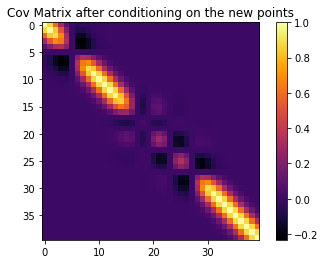

In [37]:
# Noise free training data
X_train = np.array([-15,-3,-1,3,7]).reshape(-1,1)
f = np.sin(X_train)

# Compute the mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, f, l=2, η=1, sigma_y=1e-8)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

m = plt.imshow(cov_s, cmap="inferno", interpolation='none')
plt.colorbar(m)
plt.title('Cov Matrix after conditioning on the new points')
plt.show()

Notice that the diagonal is now very different from what we've seen before. Where our new points are located we can find very low values in the matrix, which makes our multivariate normal realization pass by those points and, at the same time, reduces the uncertainty in the exact point to zero (no noise) and around that point.

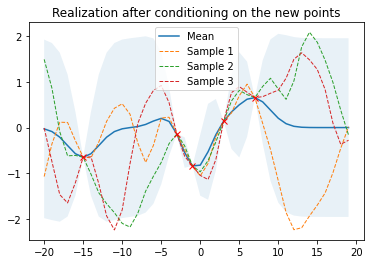

In [34]:
plot_gp(mu_s, cov_s, X, X_train=X_train, f = f, samples=samples)
plt.title('Realization after conditioning on the new points');